In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
#from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp  
    
# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import os
from glob import glob

if not os.path.exists('../paper/figs'):
    os.makedirs('../paper/figs')

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierTopDownOnlyLast.py', '../models/Vanilla.py', '../models/SimplifierBottomUp1e-2.py', '../models/SimplifierBottomUp1e-4.py', '../models/SimplifierBottomUp1e-6.py', '../models/SimplifierTopDown1e-2.py', '../models/SimplifierBottomUp1e-1.py', '../models/SimplifierBottomUp1e-0.py', '../models/SimplifierTopDown1e-1.py', '../models/SimplifierBottomUp.py', '../models/SimplifierTopDown1e-10.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDown1e-6.py', '../models/SimplifierTopDown1e-4.py', '../models/SimplifierBottomUp1e-10.py', '../models/SimplifierTopDown.py', '../models/SimplifierTopDown1e-0.py'] ['Top Down (only last)', 'Without simplify', 'Bottom Up 1e-2', 'Bottom Up 1e-4', 'Bottom Up 1e-6', 'Top Down 1e-2', 'Bottom Up 1e-1', 'Bottom Up 1e-0', 'Top Down 1e-1', 'Bottom Up', 'Top Down 1e-10', 'Bottom Up (only last)', 'Top Down 1e-6', 'Top Down 1e-4', 'Bottom Up 1e-10', 'Top Down', 'Top Down 1e-0']
(180, 14)
['Without simplify' 'Bottom Up' 'Top Dow

model
Bottom Up    -5.51 \pm 46.33
Top Down     -6.16 \pm 45.26
dtype: object

Bottom Up greater TtestResult(statistic=-2.4928714324795775, pvalue=0.9922511846463475, df=59)
Bottom Up less TtestResult(statistic=-2.4928714324795775, pvalue=0.00774881535365249, df=59)
Top Down greater TtestResult(statistic=-2.355349432390633, pvalue=0.9890752128219443, df=59)
Top Down less TtestResult(statistic=-2.355349432390633, pvalue=0.010924787178055664, df=59)


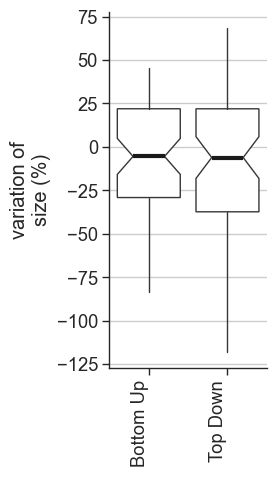

model
Bottom Up    -143.93 \pm 4980.46
Top Down      -45.67 \pm 6019.91
dtype: object

Bottom Up greater TtestResult(statistic=-1.5612556534177346, pvalue=0.9380940791093156, df=59)
Bottom Up less TtestResult(statistic=-1.5612556534177346, pvalue=0.06190592089068436, df=59)
Top Down greater TtestResult(statistic=-2.287862645654217, pvalue=0.9871269509196411, df=59)
Top Down less TtestResult(statistic=-2.287862645654217, pvalue=0.012873049080358885, df=59)


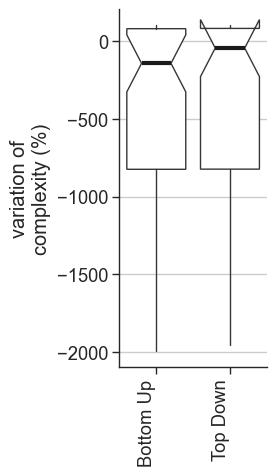

model
Bottom Up     0.86 \pm 94.29
Top Down     1.78 \pm 117.85
dtype: object

Bottom Up greater TtestResult(statistic=2.652264734520043, pvalue=0.005147549134029564, df=58)
Bottom Up less TtestResult(statistic=2.652264734520043, pvalue=0.9948524508659704, df=58)
Top Down greater TtestResult(statistic=1.9574343239309546, pvalue=0.027557119685254823, df=58)
Top Down less TtestResult(statistic=1.9574343239309546, pvalue=0.9724428803147452, df=58)


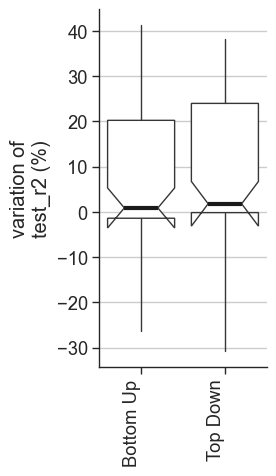

model
Bottom Up     -2.48 \pm 292.82
Top Down     -11.30 \pm 166.14
dtype: object

Bottom Up greater TtestResult(statistic=-1.1900257444677056, pvalue=0.8805576737503502, df=58)
Bottom Up less TtestResult(statistic=-1.1900257444677056, pvalue=0.11944232624964976, df=58)
Top Down greater TtestResult(statistic=-1.5712577019591056, pvalue=0.939218671062447, df=58)
Top Down less TtestResult(statistic=-1.5712577019591056, pvalue=0.06078132893755295, df=58)


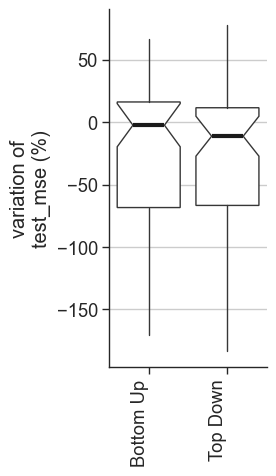

In [2]:
baseline_convergence = (results_df.loc[results_df['model'] == 'Without simplify'].groupby(['dataset', 'random_state']))

for metric in ['size', 'complexity', 'test_r2', 'test_mse']:
    speeds    = []
    for (model, dataset, random_state), group_df in \
        results_df.loc[results_df['model'] != 'Without simplify'].groupby(['model', 'dataset', 'random_state']):
        # 'contextual' is used as a hue in the plots

        baseline_curve = baseline_convergence.get_group((dataset, random_state))
        
        metric_baseline = baseline_curve[metric].values[0]
        metric_model = group_df[metric].values[0]
        speeds.append( (model, dataset, (metric_model-metric_baseline)*100/metric_model) )

    speeds_df = pd.DataFrame(data=speeds, columns=['model', 'dataset', 'delta'])

    display(speeds_df.groupby(['model'])
            .agg(['median','mad'])
            .applymap(lambda x: '{0:.2f}'.format(x))
            .agg(r' \pm '.join, axis=1)
            )

    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_1samp.html
    for model in speeds_df['model'].unique():
        print(model, 'greater',
              ttest_1samp(
                  (speeds_df[speeds_df['model']==model])['delta'].dropna(),
                  popmean=0.0, alternative='greater'
              )
        )
        print(model, 'less',
              ttest_1samp(
                  (speeds_df[speeds_df['model']==model])['delta'].dropna(),
                  popmean=0.0, alternative='less'
              )
        )

    g=sns.catplot( data=speeds_df, y=f'delta', x='model', 
        #col='dataset', col_wrap=col_wrap, # remove col to aggregate all speed ups into one plot
        legend_out=False, aspect=0.6,
        order = [o for o in order if o != 'Without simplify'], # The first is Baseline
        **boxplot_kwargs, sharey=False
    )

    # g.set(yscale="log")

    g.set_titles("{col_name}").set_axis_labels("", f"variation of\n{metric} (%)")

    # iterate through each subplot / Facet
    single_plot = True
    for (ds, plot_ax) in g._axes_dict.items():
        single_plot = False
        plot_ax.grid(which='major', axis='y', linewidth=1)
        #plot_ax.axhline(100.0, c='k', zorder=-999, linewidth=1.5)
        
        for tick in plot_ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

        # Contextual vs non-contextual
        pairs = [('D-TS', 'C-D-TS'), ('D-UCB1', 'C-D-UCB1')]

        if False:
            annotator = Annotator(
                plot_ax, pairs, data=speeds_df[(speeds_df['dataset']==ds)],
                x='model', y='Speed up',
                order=order[1:])
            annotator.reset_configuration()
            annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                comparisons_correction="holm", verbose=1, text_offset=-3)
            
            # Calculate and annotate
            annotator.apply_and_annotate()
            
    if single_plot: 
        g.ax.grid(which='major', axis='y', linewidth=1)
        #g.ax.axhline(1.0, c='k', zorder=-999, linewidth=1.5)
        
        for tick in g.ax.get_xticklabels():
            tick.set(rotation=90, ha="right")

    plt.tight_layout()
    plt.savefig(f"../paper/figs/delta_{metric}.pdf")
    plt.savefig(f"../paper/figs/delta_{metric}.png")
    plt.show()